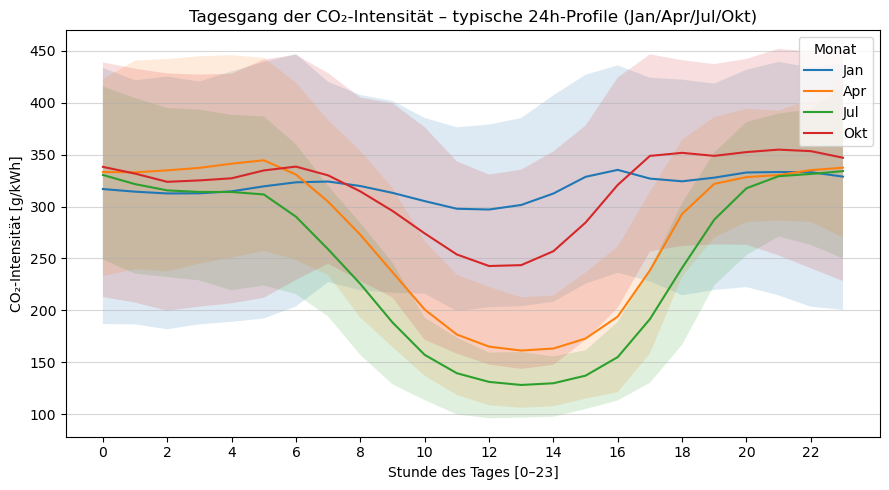

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV einlesen und CO2-Spalte zu float konvertieren
csv_path = r"C:\Users\asus\Desktop\Masterarbeit\Realisierte Erzeugung\CO2_Tagesgang.csv"
df = pd.read_csv(
    csv_path,
    sep=";", decimal=",", parse_dates=["Datum von"], dayfirst=True
)
df["CO2_g_per_kWh"] = pd.to_numeric(df["CO2_g_per_kWh"], errors="coerce")

# Funktion für Tagesprofile
def diurnal_profile_for_month(dfin, month, value_col="CO2_g_per_kWh"):
    sel = dfin.index.month == month
    d = dfin.loc[sel, value_col]
    grp = d.groupby(d.index.hour)
    return pd.DataFrame({
        "mean": grp.mean(),
        "p25": grp.quantile(0.25),
        "p75": grp.quantile(0.75)
    })

# Index setzen
df = df.set_index("Datum von")

# Monate auswählen
months = {1: "Jan", 4: "Apr", 7: "Jul", 10: "Okt"}
profiles = {name: diurnal_profile_for_month(df, m) for m, name in months.items()}

# Plotten
plt.figure(figsize=(9, 5))
for name, prof in profiles.items():
    plt.fill_between(prof.index, prof["p25"], prof["p75"], alpha=0.15)
    plt.plot(prof.index, prof["mean"], label=name)

plt.xlabel("Stunde des Tages [0–23]")
plt.ylabel("CO₂-Intensität [g/kWh]")
plt.title("Tagesgang der CO₂-Intensität – typische 24h-Profile (Jan/Apr/Jul/Okt)")
plt.xticks(np.arange(0, 24, 2))
plt.grid(True, axis="y", alpha=0.5)
plt.legend(title="Monat")
plt.tight_layout()
plt.show()


count    21887.000000
mean       291.785759
std        131.027517
min         47.900000
25%        179.100000
50%        284.400000
75%        394.000000
max        632.200000
Name: CO2_g_per_kWh, dtype: float64


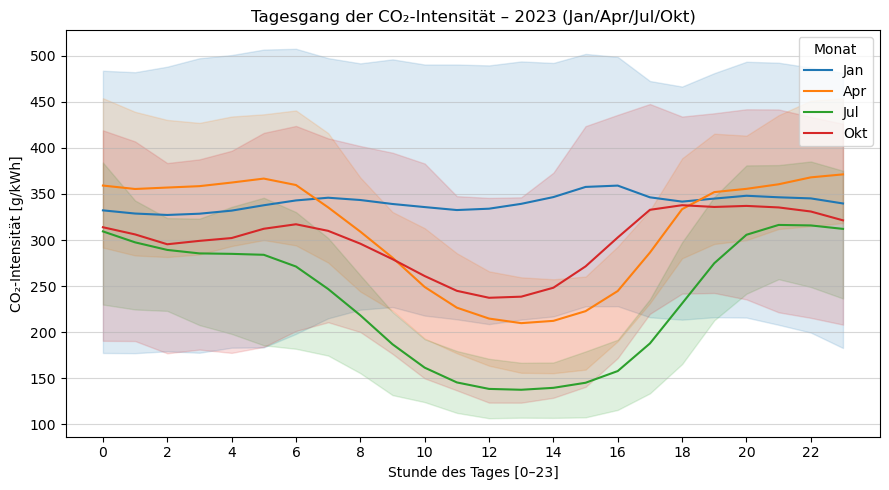

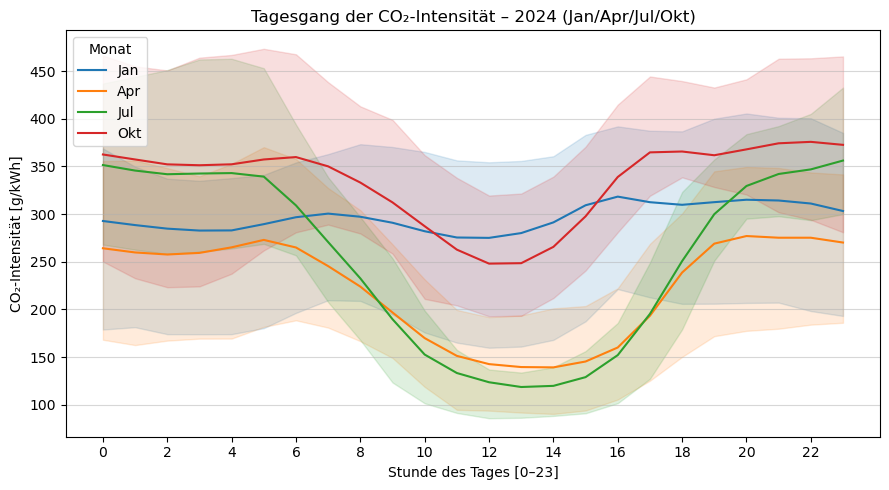

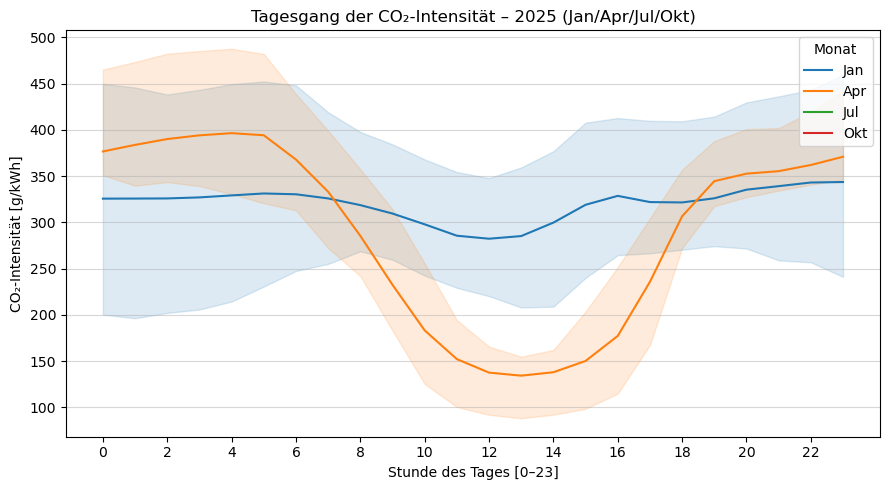


Monatsmittel (alle Jahre zusammen):
Datum von
1     319.0
2     345.2
3     312.4
4     274.5
5     231.0
6     241.1
7     245.0
8     289.1
9     300.2
10    316.4
11    342.7
12    303.9
Name: CO2_g_per_kWh, dtype: float64

Jahresmittel:
Datum von
2023    303.2
2024    283.1
2025    286.2
Name: CO2_g_per_kWh, dtype: float64


In [25]:
# =========================================================
# CO₂-Tagesgänge je Jahr (Jan/Apr/Jul/Okt) – fix gegen 3000er-Werte
# Hauptursache war bisher: Dezimal-/Tausenderzeichen wurden falsch geparst.
# Dieses Skript parst die CO2-Spalte ZEICHENWEISE korrekt – egal ob "129,8" oder "129.8".
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# -----------------------------
# 1) CSV einlesen (als STRING, damit wir selbst parsen)
# -----------------------------
csv_path = r"C:\Users\asus\Desktop\Masterarbeit\Realisierte Erzeugung\CO2_Tagesgang.csv"

df = pd.read_csv(
    csv_path,
    sep=";",                 # dein Trenner
    dtype={"CO2_g_per_kWh": "string"},  # NICHT automatisch zu Zahl machen
    parse_dates=["Datum von"],
    dayfirst=True
).set_index("Datum von").sort_index()

# -----------------------------
# 2) Robuster Parser für gemischte Zahlenformate
#    - entfernt NBSP usw.
#    - erkennt "1.234,56" (EU): '.'=Tausender, ','=Dezimal
#    - erkennt "1234,56"  (EU): ','=Dezimal
#    - erkennt "1234.56"  (US): '.'=Dezimal
#    - lässt reine Ganzzahlen durch
# -----------------------------
def parse_mixed_number(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # geschützte/Schmales NBSP entfernen
    s = s.replace("\u00A0", "").replace("\u202F", "")
    # alles außer Ziffern, Komma, Punkt, Minus entfernen (z.B. " g/kWh")
    s = re.sub(r"[^\d,.\-]", "", s)

    if "," in s and "." in s:
        # EU-Format mit Tausenderpunkt und Dezimalkomma: 1.234,56 -> 1234.56
        s = s.replace(".", "").replace(",", ".")
    elif "," in s:
        # reines Dezimalkomma: 1234,56 -> 1234.56
        s = s.replace(",", ".")
    else:
        # nur Punkt oder nur Ziffern: 1234.56 oder 1234 -> keine Änderung
        pass

    try:
        return float(s)
    except ValueError:
        return np.nan

# anwenden
df["CO2_g_per_kWh"] = df["CO2_g_per_kWh"].map(parse_mixed_number)

# Sanity-Check: Bereich ausgeben (sollte ~100–500 sein, NICHT ~3000)
print(df["CO2_g_per_kWh"].describe())

# Optional: hart abbrechen, falls weiterhin unrealistisch
if df["CO2_g_per_kWh"].max() > 1000:
    raise ValueError("CO2_g_per_kWh enthält weiterhin Werte > 1000. Bitte CSV prüfen (Skalierung/Format).")

# -----------------------------
# 3) 24h-Profil je Jahr+Monat (Mittel + IQR)
# -----------------------------
def diurnal_profile_year_month(dfin, year, month, col="CO2_g_per_kWh"):
    sel = (dfin.index.year == year) & (dfin.index.month == month)
    s = dfin.loc[sel, col].dropna()
    if s.empty:
        idx = pd.Index(range(24), name="hour")
        return pd.DataFrame({"mean": np.nan, "p25": np.nan, "p75": np.nan}, index=idx)
    g = s.groupby(s.index.hour)
    return pd.DataFrame({"mean": g.mean(), "p25": g.quantile(0.25), "p75": g.quantile(0.75)})

months = {1: "Jan", 4: "Apr", 7: "Jul", 10: "Okt"}
colors = {"Jan": "tab:blue", "Apr": "tab:orange", "Jul": "tab:green", "Okt": "tab:red"}

years = [y for y in [2023, 2024, 2025] if y in df.index.year.unique()]

# -----------------------------
# 4) Plot: pro Jahr ein Diagramm
# -----------------------------
for y in years:
    plt.figure(figsize=(9, 5))
    for m, name in months.items():
        prof = diurnal_profile_year_month(df, y, m)
        plt.fill_between(prof.index, prof["p25"], prof["p75"], alpha=0.15, color=colors[name])
        plt.plot(prof.index, prof["mean"], label=name, color=colors[name])
    plt.xlabel("Stunde des Tages [0–23]")
    plt.ylabel("CO₂-Intensität [g/kWh]")
    plt.title(f"Tagesgang der CO₂-Intensität – {y} (Jan/Apr/Jul/Okt)")
    plt.xticks(np.arange(0, 24, 2))
    plt.grid(True, axis="y", alpha=0.5)
    plt.legend(title="Monat")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 5) Quickchecks (zur Dokumentation)
# -----------------------------
print("\nMonatsmittel (alle Jahre zusammen):")
print(df["CO2_g_per_kWh"].groupby(df.index.month).mean().round(1))
print("\nJahresmittel:")
print(df["CO2_g_per_kWh"].groupby(df.index.year).mean().round(1))
